<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: NIRCam, calwebb_image3, source_catalog

<span style="color:red"> **Instruments Affected**</span>: e.g., FGS, MIRI, NIRCam, NIRISS, NIRSpec 

### Table of Contents

<div style="text-align: left"> 
    
<br> [Introduction](#intro)
<br> [JWST CalWG Algorithm](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description](#description)
<br> [Data Description](#data_descr)
<br> [Set up Temporary Directory](#tempdir)
<br> [Imports](#imports)
<br> [Loading the Data](#data_load)
<br> [Run the Image3Pipeline](#pipeline)
<br> [Perform Visual Inspection](#visualization) 
<br> [Manually Find Matches](#manual)
<br> [About This Notebook](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This is the NIRCam validation notebook for the Source Catalog step, which generates a catalog based on input exposures.

* Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/source_catalog/index.html

* Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/source_catalog

[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm

This is the NIRCam imaging validation notebook for the Source Catalog step, which uses image combinations or stacks of overlapping images to generate "browse-quality" source catalogs.  Having automated source catalogs will help accelerate the science output of JWST. The source catalogs should include both point and "slightly" extended sources at a minimum.  The catalog should provide an indication if the source is a point or an extended source. For point sources, the source catalog should include measurements corrected to infinite aperture using aperture corrections provided by a reference file.  

See: 
* https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Point+Source+Catalog


[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms

* JWST: James Webb Space Telescope

* NIRCam: Near-Infrared Camera


[Top of Page](#title_ID)

<a id="description"></a>
# Test Description

Here we generate the source catalog and visually inspect a plot of the image with the source catalog overlaid. We also look at some other diagnostic plots and then cross-check the output catalog against Mirage catalog inputs. 


[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

The set of data used in this test were created with the Mirage simulator. The simulator created a NIRCam imaging mode exposures for the short wave NRCA1 detector. 


[Top of Page](#title_ID)

<a id="tempdir"></a>
# Set up Temporary Directory
The following cell sets up a temporary directory (using python's `tempfile.TemporaryDirectory()`), and changes the script's active directory into that directory (using python's `os.chdir()`). This is so that, when the notebook is run through, it will download files to (and create output files in) the temporary directory rather than in the notebook's directory. This makes cleanup significantly easier (since all output files are deleted when the notebook is shut down), and also means that different notebooks in the same directory won't interfere with each other when run by the automated webpage generation process.

If you want the notebook to generate output in the notebook's directory, simply don't run this cell.

If you have a file (or files) that are kept in the notebook's directory, and that the notebook needs to use while running, you can copy that file into the directory (the code to do so is present below, but commented out).

In [1]:
#****
#
# Set this variable to False to not use the temporary directory
#
#****
use_tempdir = True

# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil

if use_tempdir:
    data_dir = TemporaryDirectory()

    # If you have files that are in the notebook's directory, but that the notebook will need to use while
    # running, copy them into the temporary directory here.
    #
    # files = ['name_of_file']
    # for file_name in files:
    #     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

    # Save original directory
    orig_dir = os.getcwd()

    # Move to new directory
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp7tb15s07


[Top of Page](#title_ID)

## If Desired, set up CRDS to use a local cache

By default, the notebook template environment sets up its CRDS cache (the "CRDS_PATH" environment variable) in /grp/crds/cache. However, if the notebook is running on a local machine without a fast and reliable connection to central storage, it makes more sense to put the CRDS cache locally. Currently, the cell below offers several options, and will check the supplied boolean variables one at a time until one matches.

* if `use_local_crds_cache` is False, then the CRDS cache will be kept in /grp/crds/cache
* if `use_local_crds_cache` is True, the CRDS cache will be kept locally
  * if `crds_cache_tempdir` is True, the CRDS cache will be kept in the temporary directory
  * if `crds_cache_notebook_dir` is True, the CRDS cache will be kept in the same directory as the notebook.
  * if `crds_cache_home` is True, the CRDS cache will be kept in $HOME/crds/cache
  * if `crds_cache_custom_dir` is True, the CRDS cache will be kept in whatever is stored in the 
    `crds_cache_dir_name` variable.

If the above cell (creating a temporary directory) is not run, then setting `crds_cache_tempdir` to True will store the CRDS cache in the notebook's directory (the same as setting `crds_cache_notebook_dir` to True).

In [2]:
import os

# Choose CRDS cache location
use_local_crds_cache = False
crds_cache_tempdir = False
crds_cache_notebook_dir = False
crds_cache_home = False
crds_cache_custom_dir = False
crds_cache_dir_name = ""

if use_local_crds_cache:
    if crds_cache_tempdir:
        os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_notebook_dir:
        try:
            os.environ['CRDS_PATH'] = os.path.join(orig_dir, "crds")
        except Exception as e:
            os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_home:
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif crds_cache_custom_dir:
        os.environ['CRDS_PATH'] = crds_cache_dir_name

[Top of Page](#title_ID)

<a id="imports"></a>
# Imports
List the package imports and why they are relevant to this notebook.


* astropy for various tools and packages
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for JWST Pipeline data models
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

In [3]:
# plotting, the inline must come before the matplotlib import
%matplotlib inline
# %matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

from matplotlib import pyplot as plt
import matplotlib.patches as patches

params = {'legend.fontsize': 6,
          'figure.figsize': (8, 8),
          'figure.dpi': 150,
         'axes.labelsize': 6,
         'axes.titlesize': 6,
         'xtick.labelsize':6,
         'ytick.labelsize':6}
plt.rcParams.update(params)

# Box download imports 
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

# python general
import os
import numpy as np

# astropy modules
import astropy
from astropy.io import fits
from astropy.table import QTable, Table, vstack, unique
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import units as u
import photutils

# jwst 
from jwst.pipeline import calwebb_image3
from jwst import datamodels

In [4]:
def create_image(data_2d, xpixel=None, ypixel=None, title=None):
    ''' Function to generate a 2D image of the data, 
    with an option to highlight a specific pixel.
    '''
    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot()

    norm = simple_norm(data_2d, 'sqrt', percent=99.)
    
    plt.imshow(data_2d, norm=norm, origin='lower', cmap='gray')
    
    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker='o', color='red', label='Selected Pixel')

    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    
    if title:
        plt.title(title)

    plt.subplots_adjust(left=0.15)
    plt.colorbar(label='MJy/sr')

In [5]:
def create_image_with_cat(data_2d, catalog, flux_limit=None, title=None):
    ''' Function to generate a 2D image of the data, 
    with sources overlaid.
    '''
    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot()

    norm = simple_norm(data_2d, 'sqrt', percent=99.)
    
    plt.imshow(data_2d, norm=norm, origin='lower', cmap='gray')
    
    for row in catalog:
        if flux_limit:
            if np.isnan(row['aper_total_flux']):
                pass
            else:
                if row['aper_total_flux'] > flux_limit:
                    plt.plot(row['xcentroid'], row['ycentroid'], marker='o', markersize='3', color='red')
        else:
            plt.plot(row['xcentroid'], row['ycentroid'], marker='o', markersize='1', color='red')

    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    
    if title:
        plt.title(title)

    plt.subplots_adjust(left=0.15)
    plt.colorbar(label='MJy/sr')

In [6]:
def create_scatterplot(catalog_colx, catalog_coly, title=None):
    ''' Function to generate a generic scatterplot.
    '''
    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot()
    ax.scatter(catalog_colx,catalog_coly) 
    plt.xlabel(catalog_colx.name)
    plt.ylabel(catalog_coly.name)

    
    if title:
        plt.title(title)

In [7]:
def get_input_table(sourcelist):
    '''Function to read in and access the simulator source input files.'''

    all_source_table = Table()

    # point source and galaxy source tables have different headers
    # change column headers to match for filtering later
    if "point" in sourcelist:
        col_names = ["RA", "Dec", "RA_degrees", "Dec_degrees",
                     "PixelX", "PixelY", "Magnitude",
                     "counts_sec", "counts_frame"]
    elif "galaxy" in sourcelist:
        col_names = ["PixelX", "PixelY", "RA", "Dec",
                     "RA_degrees", "Dec_degrees", "V2", "V3", "radius",
                     "ellipticity", "pos_angle", "sersic_index",
                     "Magnitude", "countrate_e_s", "counts_per_frame_e"]
    else:
        print('Error! Source list column names need to be defined.')
        sys.exit(0)

    # read in the tables
    input_source_table = Table.read(sourcelist,format='ascii')
    orig_colnames = input_source_table.colnames

    # only grab values for source catalog analysis
    short_source_table = Table({'In_RA': input_source_table['RA_degrees'],
                              'In_Dec': input_source_table['Dec_degrees']},
                              names=['In_RA', 'In_Dec'])

    # combine source lists into one master list
    all_source_table = vstack([all_source_table, short_source_table])

    # set up columns to track which sources were detected by Photutils
    all_source_table['Out_RA'] = np.nan
    all_source_table['Out_Dec'] = np.nan
    all_source_table['Detected'] = 'N'
    all_source_table['RA_Diff'] = np.nan
    all_source_table['Dec_Diff'] = np.nan

    # filter by RA, Dec (for now)
    no_duplicates = unique(all_source_table,keys=['In_RA','In_Dec'])

    return no_duplicates

[Top of Page](#title_ID)

<a id="data_load"></a>
# Loading the Data

The simulated exposures used for this test are stored in Box. Grab them. 

In [8]:
def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)

file_urls = ['https://stsci.box.com/shared/static/72fds4rfn4ppxv2tuj9qy2vbiao110pc.fits', 
             'https://stsci.box.com/shared/static/gxwtxoz5abnsx7wriqligyzxacjoz9h3.fits', 
             'https://stsci.box.com/shared/static/tninaa6a28tsa1z128u3ffzlzxr9p270.fits',
             'https://stsci.box.com/shared/static/g4zlkv9qi0vc5brpw2lamekf4ekwcfdn.json',
             'https://stsci.box.com/shared/static/kvusxulegx0xfb0uhdecu5dp8jkeluhm.list']

file_names = ['jw00042002001_01101_00004_nrca5_cal.fits', 
             'jw00042002001_01101_00005_nrca5_cal.fits', 
             'jw00042002001_01101_00006_nrca5_cal.fits',
             'level3_lw_imaging_files_asn.json',
             'jw00042002001_01101_00004_nrca5_uncal_galaxySources.list']

box_download_list = [(url,name) for url,name in zip(file_urls,file_names)]

In [9]:
get_box_files(box_download_list)

[Top of Page](#title_ID)

<a id="pipeline"></a>
# Run the Image3Pipeline

Run calwebb_image3 to get the output source catalog and the final 2D image. 

In [10]:
img3 = calwebb_image3.Image3Pipeline()

2021-07-27 02:28:04,318 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2021-07-27 02:28:04,321 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-07-27 02:28:04,323 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2021-07-27 02:28:04,325 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2021-07-27 02:28:04,327 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-07-27 02:28:04,329 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2021-07-27 02:28:04,331 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


In [11]:
img3.assign_mtwcs.skip=True
img3.save_results=True
img3.resample.save_results=True
img3.source_catalog.snr_threshold = 5
img3.source_catalog.save_results=True

In [12]:
img3.run(file_names[3])

2021-07-27 02:28:04,521 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('level3_lw_imaging_files_asn.json',).


2021-07-27 02:28:04,527 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, 'brightest': 

2021-07-27 02:28:05,070 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw00042002001_01101_00004_nrca5_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-07-27 02:28:05,458 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_nircam_abvegaoffset_0001.asdf'.


2021-07-27 02:28:05,461 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_nircam_apcorr_0004.fits'.


2021-07-27 02:28:05,464 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.


2021-07-27 02:28:05,466 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-07-27 02:28:06,259 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2021-07-27 02:28:06,262 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 15, 'searchrad': 1.0, 'use2dhist': True, 'separation': 0.5, 'tolerance': 1.0, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'general', 'nclip': 3, 'sigma': 3.0, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2021-07-27 02:28:10,422 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 704 sources in jw00042002001_01101_00004_nrca5_cal.fits.


2021-07-27 02:28:14,321 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 716 sources in jw00042002001_01101_00005_nrca5_cal.fits.


2021-07-27 02:28:17,924 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 678 sources in jw00042002001_01101_00006_nrca5_cal.fits.


2021-07-27 02:28:18,045 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:28:18,046 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 3.


2021-07-27 02:28:18,046 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2021-07-27 02:28:18,067 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw00042002001_01101_00004_nrca5_cal':


2021-07-27 02:28:18,068 - stpipe.Image3Pipeline.tweakreg - INFO -      jw00042002001_01101_00004_nrca5_cal


2021-07-27 02:28:18,089 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw00042002001_01101_00005_nrca5_cal':


2021-07-27 02:28:18,089 - stpipe.Image3Pipeline.tweakreg - INFO -      jw00042002001_01101_00005_nrca5_cal


2021-07-27 02:28:18,108 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'jw00042002001_01101_00006_nrca5_cal':


2021-07-27 02:28:18,109 - stpipe.Image3Pipeline.tweakreg - INFO -      jw00042002001_01101_00006_nrca5_cal


2021-07-27 02:28:18,109 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:28:18,109 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-07-27 02:28:18,110 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2021-07-27 02:28:18.109724


2021-07-27 02:28:18,110 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.2


2021-07-27 02:28:18,110 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-07-27 02:28:18,264 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: jw00042002001_01101_00004_nrca5_cal' as reference image


2021-07-27 02:28:18,272 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw00042002001_01101_00005_nrca5_cal' to the reference catalog.


2021-07-27 02:28:18,426 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw00042002001_01101_00005_nrca5_cal' catalog with sources from the reference 'jw00042002001_01101_00004_nrca5_cal' catalog.


2021-07-27 02:28:18,427 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...


2021-07-27 02:28:18,432 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 0.001568, -0.006337 with significance of 110.8 and 663 matches.


2021-07-27 02:28:18,434 - stpipe.Image3Pipeline.tweakreg - INFO - Found 463 matches for 'GROUP ID: jw00042002001_01101_00005_nrca5_cal'...


2021-07-27 02:28:18,435 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'general' fit


2021-07-27 02:28:18,439 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'general' fit for GROUP ID: jw00042002001_01101_00005_nrca5_cal:


2021-07-27 02:28:18,440 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.00164527  YSH: 0.0335188    PROPER ROT: -0.000950555    


2021-07-27 02:28:18,440 - stpipe.Image3Pipeline.tweakreg - INFO - <ROT>: -0.000950555  SKEW: -0.022778    ROT_X: 0.0104384  ROT_Y: -0.0123395


2021-07-27 02:28:18,441 - stpipe.Image3Pipeline.tweakreg - INFO - <SCALE>: 1.00031  SCALE_X: 1.00061  SCALE_Y: 1


2021-07-27 02:28:18,441 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:28:18,442 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0228544   FIT MAE: 0.0132534


2021-07-27 02:28:18,442 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 454 objects.


2021-07-27 02:28:18,477 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: jw00042002001_01101_00006_nrca5_cal' to the reference catalog.


2021-07-27 02:28:18,677 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'jw00042002001_01101_00006_nrca5_cal' catalog with sources from the reference 'jw00042002001_01101_00004_nrca5_cal' catalog.


2021-07-27 02:28:18,678 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...


2021-07-27 02:28:18,682 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 0.007108, -0.002618 with significance of 116 and 809 matches.


2021-07-27 02:28:18,684 - stpipe.Image3Pipeline.tweakreg - INFO - Found 545 matches for 'GROUP ID: jw00042002001_01101_00006_nrca5_cal'...


2021-07-27 02:28:18,685 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'general' fit


2021-07-27 02:28:18,689 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'general' fit for GROUP ID: jw00042002001_01101_00006_nrca5_cal:


2021-07-27 02:28:18,690 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.0266754  YSH: 0.0103281    PROPER ROT: -4.94012e-05    


2021-07-27 02:28:18,690 - stpipe.Image3Pipeline.tweakreg - INFO - <ROT>: -4.94012e-05  SKEW: 0.0107724    ROT_X: -0.00543559  ROT_Y: 0.00533678


2021-07-27 02:28:18,691 - stpipe.Image3Pipeline.tweakreg - INFO - <SCALE>: 0.999836  SCALE_X: 0.999861  SCALE_Y: 0.999811


2021-07-27 02:28:18,692 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:28:18,692 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0229117   FIT MAE: 0.00967974


2021-07-27 02:28:18,693 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 534 objects.


2021-07-27 02:28:18,727 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-07-27 02:28:18,728 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2021-07-27 02:28:18.727818


2021-07-27 02:28:18,728 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:00.618094


2021-07-27 02:28:18,729 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-07-27 02:28:18,804 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2021-07-27 02:28:18,915 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-07-27 02:28:18,917 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2021-07-27 02:28:18,967 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:28:18,968 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2021-07-27 02:28:18.967420


2021-07-27 02:28:18,969 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:28:18,969 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2021-07-27 02:28:18,970 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2021-07-27 02:28:18,970 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2021-07-27 02:28:18,971 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:28:18,971 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2021-07-27 02:28:20,729 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw00042002001_01101_00004_nrca5_cal.fits. Sky background: 0.00111583


2021-07-27 02:28:20,731 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw00042002001_01101_00005_nrca5_cal.fits. Sky background: 0


2021-07-27 02:28:20,732 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw00042002001_01101_00006_nrca5_cal.fits. Sky background: 0.000731449


2021-07-27 02:28:20,733 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:28:20,733 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2021-07-27 02:28:21,066 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:28:21,067 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 0.03651382158824229 [not converted]


2021-07-27 02:28:21,067 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:28:21,068 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2021-07-27 02:28:21,069 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw00042002001_01101_00004_nrca5_cal.fits. Sky background: 0.0376297 (old=0.00111583, delta=0.0365138)


2021-07-27 02:28:21,069 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw00042002001_01101_00005_nrca5_cal.fits. Sky background: 0.0365138 (old=0, delta=0.0365138)


2021-07-27 02:28:21,070 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=jw00042002001_01101_00006_nrca5_cal.fits. Sky background: 0.0372453 (old=0.000731449, delta=0.0365138)


2021-07-27 02:28:21,070 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:28:21,071 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2021-07-27 02:28:21.070775


2021-07-27 02:28:21,072 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:02.103355


2021-07-27 02:28:21,072 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:28:21,078 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-07-27 02:28:21,179 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2021-07-27 02:28:21,181 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-07-27 02:28:21,185 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 3 inputs


2021-07-27 02:28:26,057 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:28:34,372 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:28:42,590 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:28:46,503 - stpipe.Image3Pipeline.outlier_detection - INFO - Generating median from 3 images


2021-07-27 02:28:48,243 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2021-07-27 02:28:53,048 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2246, 2456)


2021-07-27 02:28:59,780 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2246, 2456)


2021-07-27 02:29:06,490 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2246, 2456)


2021-07-27 02:29:09,593 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in jw00042002001_01101_00004_nrca5_a3001_crf.fits


2021-07-27 02:29:09,777 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in jw00042002001_01101_00005_nrca5_a3001_crf.fits


2021-07-27 02:29:09,960 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in jw00042002001_01101_00006_nrca5_a3001_crf.fits


2021-07-27 02:29:09,962 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-07-27 02:29:10,110 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-07-27 02:29:10,112 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-07-27 02:29:10,132 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits


2021-07-27 02:29:10,266 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for lw_imaging


2021-07-27 02:29:10,827 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2021-07-27 02:29:13,601 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:29:19,232 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:29:24,828 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:29:27,151 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2021-07-27 02:29:29,891 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:29:35,661 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:29:41,356 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:29:43,902 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2021-07-27 02:29:46,600 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:29:52,323 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:29:57,937 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:30:00,416 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2021-07-27 02:30:03,148 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:30:08,800 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:30:14,413 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2246, 2456)


2021-07-27 02:30:16,898 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:30:16,901 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  215.065916169 52.907411394 215.065900360 52.946671307 214.994682012 52.946639605 214.994762380 52.907379721


2021-07-27 02:30:17,414 - stpipe.Image3Pipeline.resample - INFO - Saved model in lw_imaging_i2d.fits


2021-07-27 02:30:17,416 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-07-27 02:30:17,534 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(2246, 2456) from lw_imaging_i2d.fits>,).


2021-07-27 02:30:17,537 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 5, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-07-27 02:30:17,558 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_nircam_apcorr_0004.fits


2021-07-27 02:30:17,573 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_nircam_abvegaoffset_0001.asdf


2021-07-27 02:30:17,574 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: NIRCAM


2021-07-27 02:30:17,575 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: NRCALONG


2021-07-27 02:30:17,576 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F356W


2021-07-27 02:30:17,577 - stpipe.Image3Pipeline.source_catalog - INFO - Pupil: CLEAR


2021-07-27 02:30:17,578 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2021-07-27 02:30:17,628 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 2.82390


2021-07-27 02:30:20,147 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 2398 sources


2021-07-27 02:30:22,361 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: lw_imaging_cat.ecsv


2021-07-27 02:30:22,482 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in lw_imaging_segm.fits


2021-07-27 02:30:22,484 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: lw_imaging_segm.fits


2021-07-27 02:30:22,486 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-07-27 02:30:22,488 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


[Top of Page](#title_ID)

<a id="visualization"></a>
# Perform Visual Inspection

Perform the visual inspection of the catalog and the final image. 

In [13]:
catalog = Table.read("lw_imaging_cat.ecsv")

2021-07-27 02:30:22,648 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/io/ascii/connect.py:18: ResourceWarning: unclosed file <_io.TextIOWrapper name='lw_imaging_cat.ecsv' encoding='UTF-8'>
  return read(filename, **kwargs)



In [14]:
combined_image = datamodels.ImageModel("lw_imaging_i2d.fits")

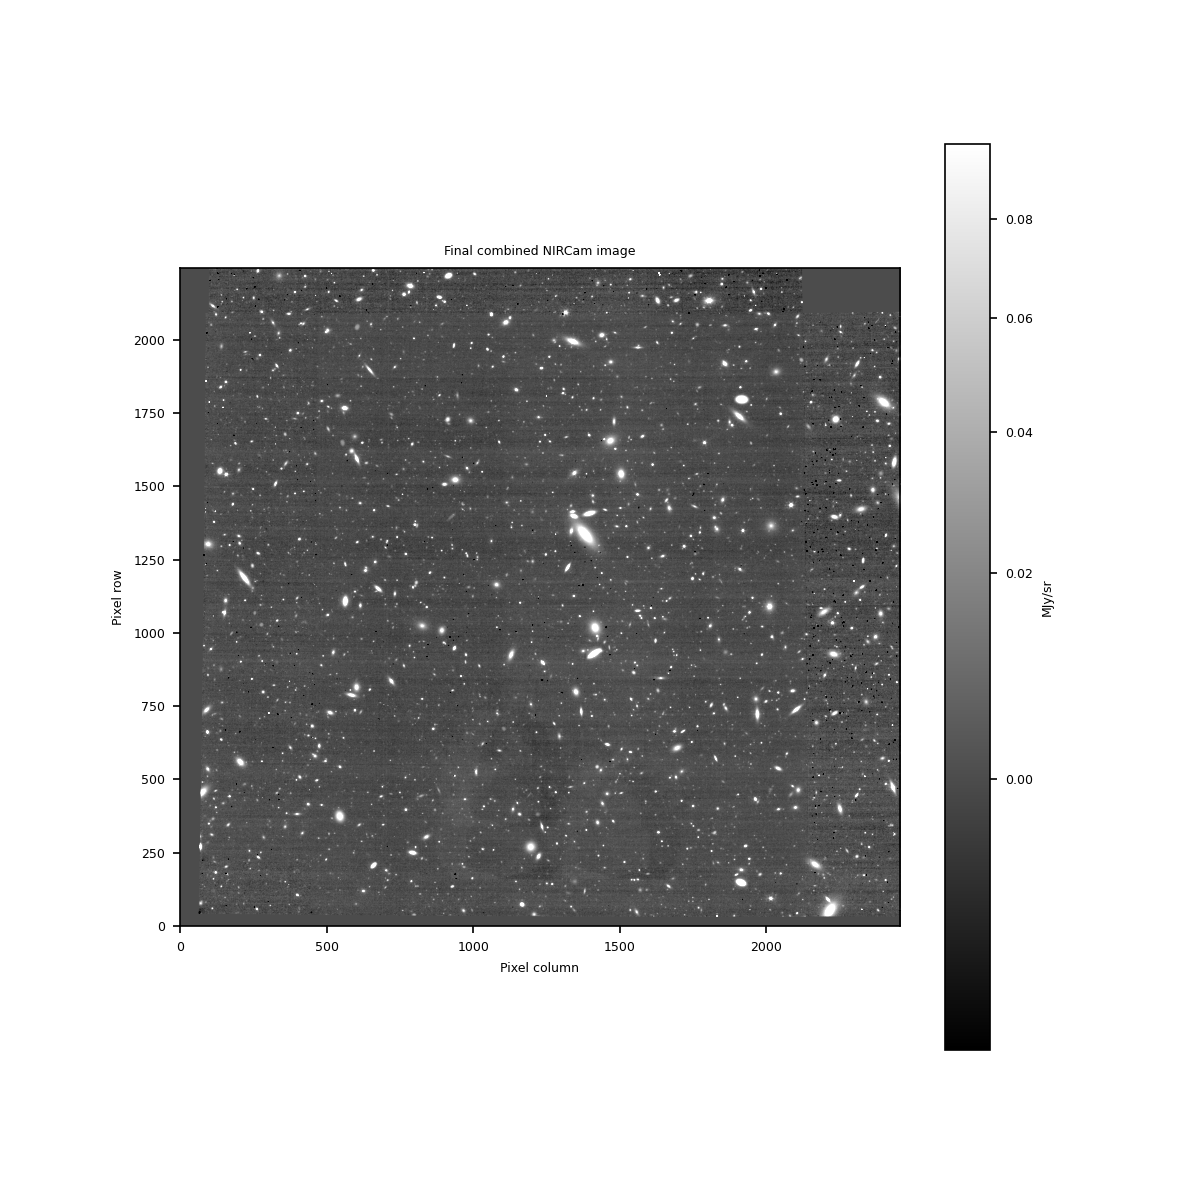

In [15]:
create_image(combined_image.data, title="Final combined NIRCam image")

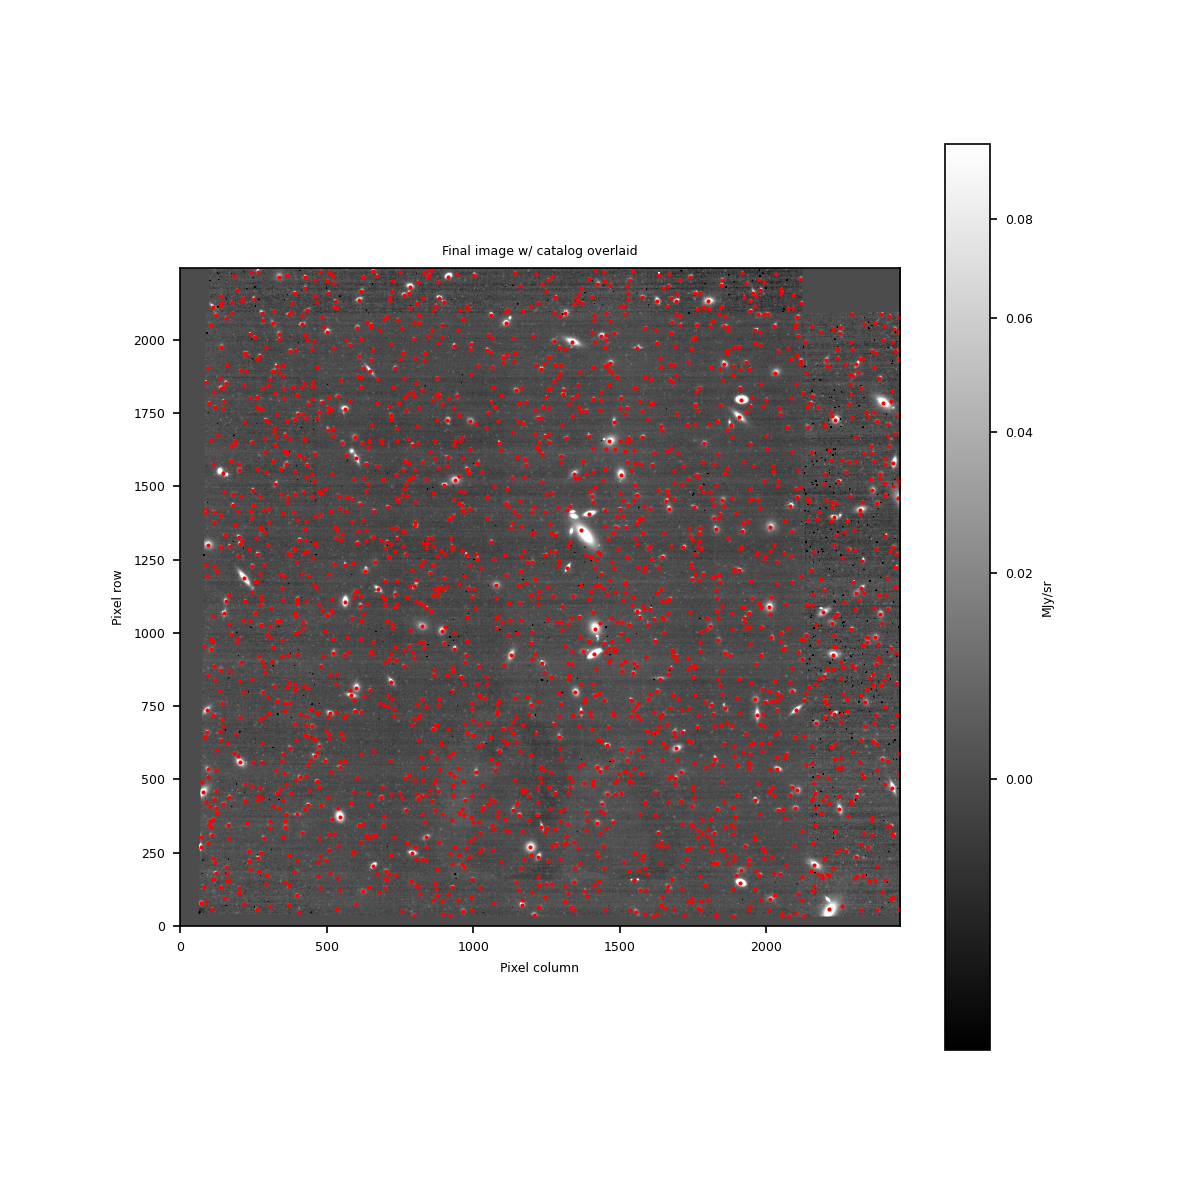

In [16]:
create_image_with_cat(combined_image.data, catalog, title="Final image w/ catalog overlaid")

In [17]:
catalog

label,xcentroid,ycentroid,sky_centroid,aper_bkg_flux,aper_bkg_flux_err,aper30_flux,aper30_flux_err,aper50_flux,aper50_flux_err,aper70_flux,aper70_flux_err,aper_total_flux,aper_total_flux_err,aper30_abmag,aper30_abmag_err,aper50_abmag,aper50_abmag_err,aper70_abmag,aper70_abmag_err,aper_total_abmag,aper_total_abmag_err,aper30_vegamag,aper30_vegamag_err,aper50_vegamag,aper50_vegamag_err,aper70_vegamag,aper70_vegamag_err,aper_total_vegamag,aper_total_vegamag_err,CI_50_30,CI_70_50,CI_70_30,is_extended,sharpness,roundness,nn_label,nn_dist,isophotal_flux,isophotal_flux_err,isophotal_abmag,isophotal_abmag_err,isophotal_vegamag,isophotal_vegamag_err,isophotal_area,semimajor_sigma,semiminor_sigma,ellipticity,orientation,sky_orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur
,,,"deg,deg",Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,pix,Jy,Jy,,,,,pix2,pix,pix,,deg,deg,"deg,deg","deg,deg","deg,deg","deg,deg"
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float32,int64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,object,object,object,object
1,1612.8180,33.2707,"215.01917064679,52.907976946168546",0.000000e+00,4.632531e-11,7.735678e-09,9.715980e-03,1.464871e-08,1.375211e-02,3.982519e-08,nan,5.826824e-08,nan,29.178754,15.247471,28.485502,14.931427,27.399605,nan,26.986420,nan,26.354854,15.247471,25.661602,14.931427,24.575705,nan,24.162520,nan,1.8937,2.7187,5.1482,False,0.777687,-0.057735,17,15.450421,3.362983e-08,2.051551e-02,27.583187,14.463396,24.759287,14.463396,11.0,1.258729,0.661480,0.474485,-71.808464,18.149219,"215.0192088922104,52.90794601483127","215.01920873690574,52.90805089434383","215.01909295789895,52.90794595233516","215.01909280231357,52.90805083184758"
2,1828.3971,33.2152,"215.01292238879813,52.90797244506119",0.000000e+00,3.244237e-11,5.538691e-06,2.471047e-01,7.866841e-06,2.838268e-01,8.154786e-06,nan,1.193127e-05,nan,22.041482,11.623709,21.660499,11.393163,21.621469,nan,21.208284,nan,19.217582,11.623709,18.836599,11.393163,18.797569,nan,18.384384,nan,1.4203,1.0366,1.4723,False,0.970525,-0.142083,15,7.822298,8.155002e-06,2.908717e-01,21.621439,11.380724,18.797539,11.380724,29.0,0.975281,0.860216,0.117981,-2.859513,87.098171,"215.01303539066072,52.90794252991855","215.01303522040595,52.90804740942166","215.01280352208008,52.907942392794716","215.01280335126384,52.90804727229745"
3,1887.3006,34.6724,"215.0112151125642,52.90799689391668",3.569111e-10,5.603706e-11,2.777492e-08,1.188986e-02,5.457994e-08,1.693087e-02,1.494806e-07,3.434491e-02,2.187050e-07,5.025004e-02,27.790868,14.078813,27.057417,13.729119,25.963538,13.403199,25.550353,13.403199,24.966968,14.078813,24.233517,13.729119,23.139638,13.403199,22.726453,13.403199,1.9651,2.7387,5.3819,False,0.606757,0.258450,30,57.407305,1.932078e-07,4.097992e-02,25.684938,13.316372,22.861038,13.316372,41.0,1.618513,1.393842,0.138813,58.662532,148.620215,"215.01132535991846,52.90794150801864","215.01132512739048,52.90808134735238","215.01109349135038,52.90794136756567","215.0110932580737,52.90808120689886"
4,2053.5395,32.7330,"215.0063969698415,52.90795997835066",0.000000e+00,2.289365e-11,1.102241e-08,1.063580e-02,2.204748e-08,1.543699e-02,3.728525e-08,nan,5.455204e-08,nan,28.794309,14.961236,28.041603,14.613011,27.471157,nan,27.057972,nan,25.970409,14.961236,25.217703,14.613011,24.647257,nan,24.234072,nan,2.0002,1.6911,3.3827,False,0.800431,-0.728395,18,12.371857,3.360831e-08,2.089283e-02,27.583883,14.483879,24.759983,14.483879,10.0,0.916502,0.711080,0.224138,-1.111719,88.845965,"215.00645612036382,52.90793846371026","215.00645599623894,52.908008383371374","215.00631120253234,52.90793837005531","215.0063110781735,52.90800828971626"
5,2077.5132,34.4371,"215.00570207200698,52.90798931561178

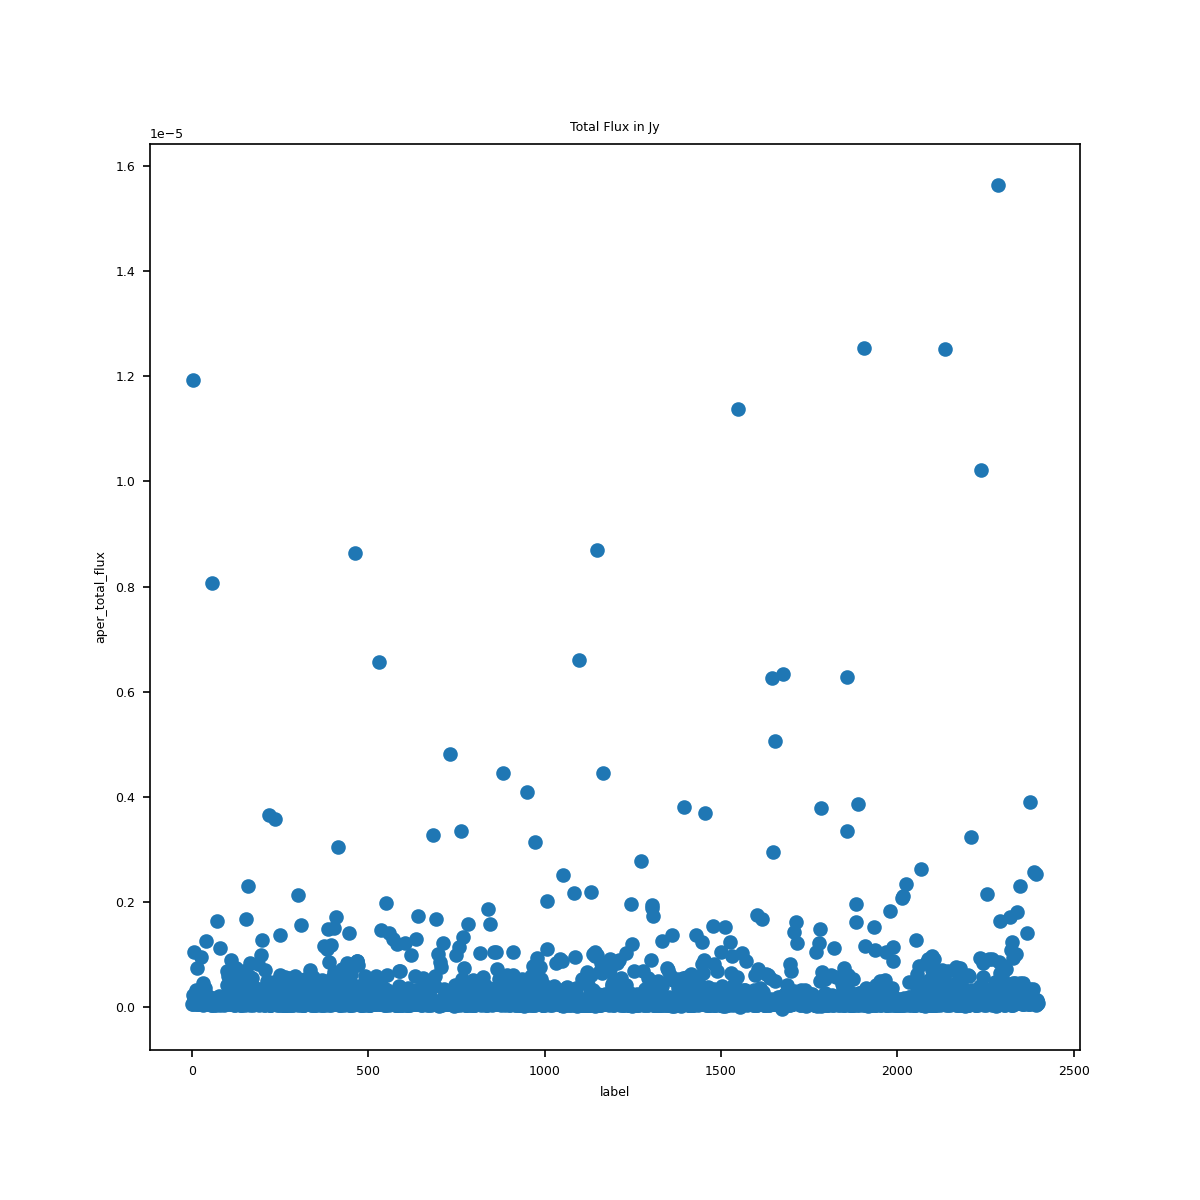

In [18]:
create_scatterplot(catalog['label'], catalog['aper_total_flux'],title='Total Flux in '+str(catalog['aper_total_flux'].unit))

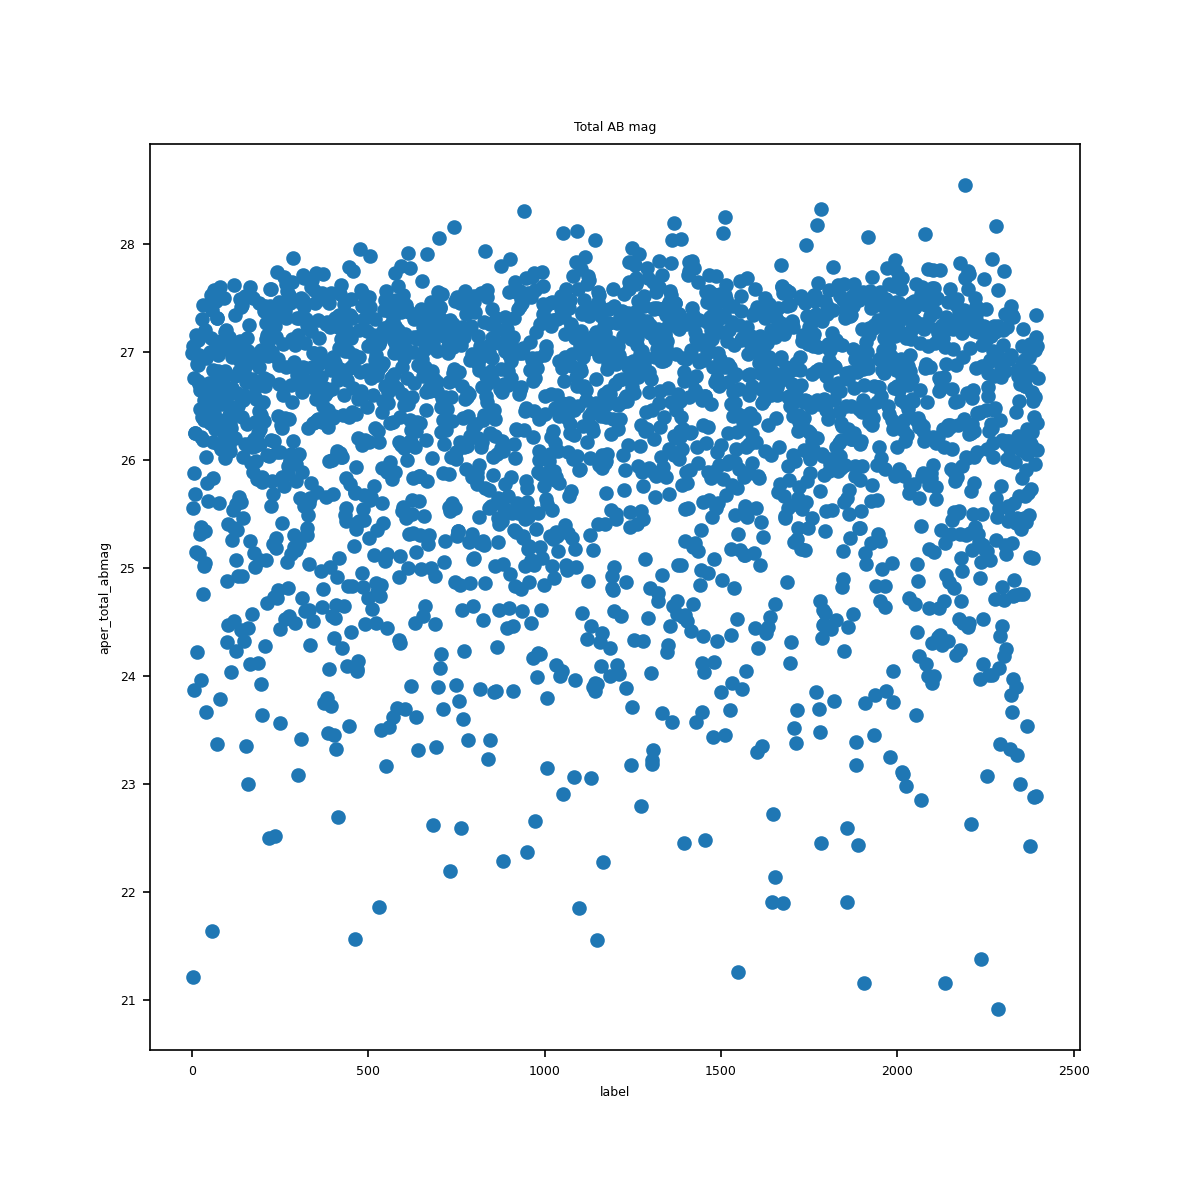

In [19]:
create_scatterplot(catalog['label'], catalog['aper_total_abmag'],title='Total AB mag')

[Top of Page](#title_ID)

<a id="manual"></a>
# Manually Find Matches 

Since this is a simulated data set, we can compare the output catalog information from the pipeline with the input catalog information used to create the simulation. Grab the input catalog RA, Dec values and the output catalog RA, Dec values.

In [20]:
test_outputs = get_input_table(file_names[4])
in_ra = test_outputs['In_RA'].data
in_dec = test_outputs['In_Dec'].data
out_ra = catalog['sky_centroid'].ra.deg
out_dec = catalog['sky_centroid'].dec.deg

Set the tolerance and initialize our counters. 

In [21]:
tol = 1.e-3
found_count=0
multiples_count=0
missed_count=0

Below we loop through the input RA, Dec values and compare them to the RA, Dec values in the output catalog. For cases where there are multiple matches for our tolerance level, count those cases. 

In [22]:
for ra,dec,idx in zip(in_ra, in_dec,range(len(test_outputs))):

    match = np.where((np.abs(ra-out_ra) < tol) & (np.abs(dec-out_dec) < tol))
    
    if np.size(match) == 1: 
        found_count +=1 
        test_outputs['Detected'][idx] = 'Y'
        test_outputs['Out_RA'][idx] = out_ra[match]
        test_outputs['Out_Dec'][idx] = out_dec[match]
        test_outputs['RA_Diff'][idx] = np.abs(ra-out_ra[match])
        test_outputs['Dec_Diff'][idx] = np.abs(dec-out_dec[match])  

    if np.size(match) > 1:  
        multiples_count +=1       
        
    if np.size(match) < 1:
        missed_count +=1

Let's see how it did. 

In [23]:
total_percent_found = (found_count/len(test_outputs))*100

print('\n')
print('SNR threshold used for pipeline: ',img3.source_catalog.snr_threshold)
print('Total found:',found_count)
print('Total missed:',missed_count)
print('Number of multiples: ',multiples_count)
print('Total number of input sources:',len(test_outputs))
print('Total number in output catalog:',len(catalog))
print('Total percent found:',total_percent_found)
print('\n')



SNR threshold used for pipeline:  5
Total found: 1839
Total missed: 1374
Number of multiples:  16282
Total number of input sources: 19495
Total number in output catalog: 2398
Total percent found: 9.433187996922287




### Use photutils to find catalog matches

Photutils includes a package to match sources between catalogs by providing a max separation value. Set that value and compare the two catalogs.

In [24]:
catalog_in = SkyCoord(ra=in_ra*u.degree, dec=in_dec*u.degree)
catalog_out = SkyCoord(ra=out_ra*u.degree, dec=out_dec*u.degree)

In [25]:
max_sep = 1.0 * u.arcsec

In [26]:
# idx, d2d, d3d = cat_in.match_to_catalog_3d(cat_out)
idx, d2d, d3d = catalog_in.match_to_catalog_sky(catalog_out)
sep_constraint = d2d < max_sep
catalog_in_matches = catalog_in[sep_constraint]
catalog_out_matches = catalog_out[idx[sep_constraint]]

Now, ```catalog_in_matches``` and ```catalog_out_matches``` are the matched sources in ```catalog_in``` and ```catalog_out```, respectively, which are separated less than our ```max_sep``` value.

In [27]:
print('Number of matched sources using max separation of '+str(max_sep)+': ',len(catalog_out_matches))

Number of matched sources using max separation of 1.0 arcsec:  7237


<a id="about_ID"></a>
## About this Notebook
**Author:** Alicia Canipe, Senior Staff Scientist, NIRCam
<br>**Updated On:** 05/26/2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 